In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import time
import datetime
from sklearn import preprocessing
from sklearn import cluster, metrics

In [3]:
rscaler = preprocessing.RobustScaler()

In [4]:
df = pd.read_csv('df.csv')
df.shape

(5929, 7)

In [93]:
def feat_eng(x,dataf):
    #build the model x
    y = pd.DataFrame(index = x['customer_unique_id'].unique())

    #feature0  = number of order
    y['n_order'] = x.groupby('customer_unique_id').order_id.count()

    #feature1  = total value of orders
    #y['payment_total'] = x.groupby('customer_unique_id').order_total.agg('sum')

    #feature2-3  = mean and std of orders
    y['payment_mean'] = x.groupby('customer_unique_id').order_total.agg('mean')
    y['payment_std'] = x.groupby('customer_unique_id').order_total.agg('std')

    #feature frequency4-10 of order on the distrib
    x['order_dis'] = pd.cut(dataf['order_total'],30, duplicates = 'drop')
    temp = pd.crosstab(x['customer_unique_id'], x['order_dis'], values = x['order_dis'], aggfunc= 'count', margins = True)
    for i in range(temp.shape[1]):
        temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)

    temp = temp.drop(labels = 'All')
    temp = temp.drop(labels = 'All', axis = 1)
    y = y.join(temp)
    #feature frequency11-135 of category
    temp = pd.crosstab(x['customer_unique_id'], x['product_category_name'], values = x['product_category_name'], aggfunc= 'count', margins = True).fillna(0)
    for i in range(temp.shape[1]):
        temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)
    temp = temp.drop(labels = 'All')
    temp = temp.drop(labels = 'All', axis = 1)
    y = y.join(temp)

    #feature136-137 review score mean and std
    y['rev_mean'] = x.groupby('customer_unique_id').review_score.agg('mean')
    y['rev_std'] = x.groupby('customer_unique_id').review_score.agg('std')
    #feature138  = days since last order
    y['days_since_last_order'] = x.groupby('customer_unique_id').days_since_order.agg('min')
    #feature139 = "age" of the custumer
    y['age'] = x.groupby('customer_unique_id').days_since_order.agg('max')
    y = y.loc[y['n_order'] > 1]
    return y

In [181]:
def simulate(x):
    start = x['days_since_order'].max()
    end = x['days_since_order'].min()
    year = start - 365
    t0 = x.loc[x['days_since_order'] > year ]
    t0 = feat_eng(t0,x)
    t0s = rscaler.fit_transform(t0.values)
    clus = cluster.KMeans(n_clusters = 50,random_state=38)
    clus.fit(t0s)
    ari_l = []
    year_n = year
    for i in range(int((year-end)/30)):
        tn = x.loc[x['days_since_order'] > year_n]
        tn = feat_eng(tn,x)
        feat_diff = [x for x in list(t0.columns) + list(tn.columns) if x not in list(t0.columns) or x not in list(tn.columns)]
        if feat_diff:
            tn = tn.drop(labels = feat_diff, axis = 1)
        tns = rscaler.fit_transform(tn.values)
        clus2 = cluster.KMeans(n_clusters = 50,random_state=38)
        tn['pred_labels'] = clus2.fit_predict(tns)
        tn['true_labels'] = clus.predict(tns)
        ari_l.append(metrics.adjusted_rand_score(np.array(tn['true_labels']), np.array(tn['pred_labels'])))
        year_n = year_n-30
    return ari_l

In [182]:
a = [0,1,2,3]
b = [0,1,2,3,4,5]
c = [x for x in a + b if x not in a or x not in b]
c

[4, 5]

In [183]:
test = simulate(df)

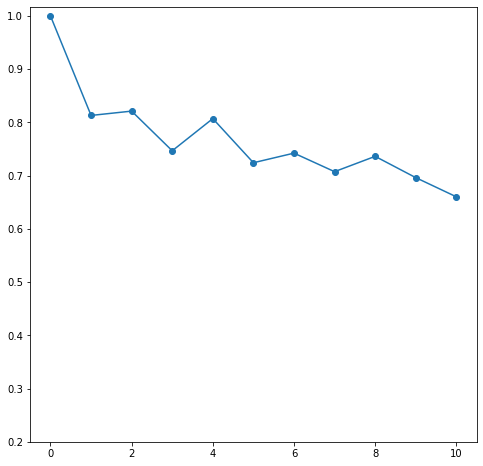

In [184]:
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(np.arange(0,len(test),1), test, marker ='o')
ax.set_ylim(bottom = 0.2)
fig.savefig('stability.png', bbox_inches = 'tight')

In [136]:
x = df
start = x['days_since_order'].max()
end = x['days_since_order'].min()
year = start - 365
t0 = x.loc[x['days_since_order'] > year ]
t0 = feat_eng(t0,df)
t0_s = rscaler.fit_transform(t0.values)
clus = cluster.KMeans(n_clusters = 40,random_state=38)
clus.fit(t0_s)
true_labels = clus.labels_
t0['true_labels'] = true_labels
ari_l = []
year_n = year
t1 = x.loc[x['days_since_order'] > (year_n-7)]
t1 = feat_eng(t1,df)
t1_s = rscaler.fit_transform(t1.values)
#clus_n = cluster.KMeans(n_clusters = 30,random_state=38)
t1['true_labels'] = clus.predict(t1_s)
clus2 = cluster.KMeans(n_clusters = 40,random_state=38)
t1['pred_labels'] = clus2.fit_predict(t1_s)
temp = pd.DataFrame(t0['true_labels']).join(t1['pred_labels'])
ari_l.append(metrics.adjusted_rand_score(np.array(t1['pred_labels']),np.array(t1['true_labels'])))


In [137]:
ari_l

[0.8369368493790004]

In [126]:
x = df
t0 = x.loc[x['days_since_order'] > year ]
t1 = x.loc[x['days_since_order'] > (year_n-1)]

In [127]:
t0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2022 entries, 0 to 5928
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   customer_unique_id        2022 non-null   object  
 1   order_id                  2022 non-null   object  
 2   order_purchase_timestamp  2022 non-null   object  
 3   order_total               2022 non-null   float64 
 4   days_since_order          2022 non-null   int64   
 5   review_score              2022 non-null   float64 
 6   product_category_name     2022 non-null   object  
 7   order_dis                 2022 non-null   category
dtypes: category(1), float64(2), int64(1), object(4)
memory usage: 130.9+ KB


In [128]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2041 entries, 0 to 5928
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   customer_unique_id        2041 non-null   object  
 1   order_id                  2041 non-null   object  
 2   order_purchase_timestamp  2041 non-null   object  
 3   order_total               2041 non-null   float64 
 4   days_since_order          2041 non-null   int64   
 5   review_score              2041 non-null   float64 
 6   product_category_name     2041 non-null   object  
 7   order_dis                 2041 non-null   category
dtypes: category(1), float64(2), int64(1), object(4)
memory usage: 132.1+ KB


In [114]:
clus.predict(t0_s)

array([ 4, 15,  3, ..., 23,  8, 27])

In [115]:
clus.predict(t1_s)

array([ 4, 15,  3, ..., 23,  8, 27])

In [116]:
clus2.fit_predict(t1_s)

array([ 4, 10,  5, ..., 21, 23, 23])

In [16]:
def expl(md_df,name):
    n_order_m = md_df.describe().iloc[1,0]
    payment_m = md_df.describe().iloc[1,1]
    rev_m_m = md_df.describe().iloc[1,-6]
    age_m = md_df.describe().iloc[1,-3]
    #build the explanatory df
    expl_df = pd.DataFrame()
    #first the frequence of the clusters
    expl_df['freq'] = md_df.groupby(name).n_order.count()
    expl_df['freq'] = round((expl_df['freq']/md_df.shape[0])*100,2)
    #the mean ,ratio and max of the number of order
    expl_df['n_order_mean'] = md_df.groupby(name).n_order.agg('mean')
    expl_df['n_order_ratio'] = round(expl_df['n_order_mean']/n_order_m,2)
    expl_df['n_order_max'] = md_df.groupby(name).n_order.agg('max')
    #the mean and the ratio of the mean of payment
    expl_df['payment_m_m'] = md_df.groupby(name).payment_mean.agg('mean')
    expl_df['payment_m_r'] = round(expl_df['payment_m_m']/payment_m,2)
    #the mean and ratio of the mean of review score
    expl_df['rev_m_m'] = md_df.groupby(name).rev_mean.agg('mean')
    expl_df['rev_ratio'] =round(expl_df['rev_m_m']/rev_m_m,2)
    #the mean and ratio of the age of each cluster
    expl_df['age_m_m'] = md_df.groupby(name).age.agg('mean')
    expl_df['age_ratio'] =round(expl_df['age_m_m']/age_m,2)
    #the top2 payment bucket for each cluster
    temp = pd.DataFrame(md_df.groupby(name).mean())
    temp = temp.iloc[:,3:18]
    temp2 = temp.T

    top1=[]
    top2=[]
    for i in range(temp2.shape[1]):    
        val = list(round(temp2.iloc[:,i].nlargest(2),2))
        cat = list(temp2.iloc[:,i].nlargest(2).index)
        cat_top2 = dict(zip(cat, val))
        cat_list = []
        for y in cat_top2:
            cat_list.append(str(y)+':'+str(cat_top2[y]))
        top1.append(cat_list[0])
        top2.append(cat_list[1])
   
       
    expl_df = expl_df.join(pd.DataFrame({'top1_pay' : top1, 'top2_pay' : top2}))
    #the top2 categories for each cluster
    temp = pd.DataFrame(md_df.groupby(name).mean())
    temp = temp.iloc[:,18:-5]
    temp2 = temp.T

    top1=[]
    top2=[]
    for i in range(temp2.shape[1]):    
        val = list(round(temp2.iloc[:,i].nlargest(2),2))
        cat = list(temp2.iloc[:,i].nlargest(2).index)
        cat_top2 = dict(zip(cat, val))
        cat_list = []
        for y in cat_top2:
            cat_list.append(str(y)+':'+str(cat_top2[y]))
        top1.append(cat_list[0])
        top2.append(cat_list[1])
   
       
    expl_df = expl_df.join(pd.DataFrame({'top1_cat' : top1, 'top2_cat' : top2}))

    return expl_df

In [17]:
lala = pd.DataFrame(expl(t1,'true_labels').sort_values(by='freq').reset_index())


In [18]:
prout = dict(zip(lala['true_labels'],lala.index))

In [19]:
t1['true_labels'] = t1['true_labels'].replace(prout)


In [20]:
t1['true_labels']

6204c4e582a95b6a350adf6988623bfb    25
d3581765bcf955dcf282b1642c74157c     6
35ecdf6858edc6427223b64804cf028e    16
8004f80e361a5ee23aadb7418a685fc2    15
0697142614905a50813d854fa08b8eaf    23
                                    ..
72e05cde2a8e5d8f08ca3ef3bcfadc63    10
24fc2d6f4c3339820a1a3746a125f8c5    15
47a71b49f98984efd3c62cb213f977e8    18
2fc5e667ccf2a1c87a798be23f1c920a     9
acc4424c209233de519e034152f30304    22
Name: true_labels, Length: 1630, dtype: int32

In [21]:
lala2 = pd.DataFrame(expl(t1,'pred_labels').sort_values(by='freq').reset_index())


In [22]:
t1['pred_labels']

6204c4e582a95b6a350adf6988623bfb    18
d3581765bcf955dcf282b1642c74157c    19
35ecdf6858edc6427223b64804cf028e    22
8004f80e361a5ee23aadb7418a685fc2     2
0697142614905a50813d854fa08b8eaf     3
                                    ..
72e05cde2a8e5d8f08ca3ef3bcfadc63    10
24fc2d6f4c3339820a1a3746a125f8c5     2
47a71b49f98984efd3c62cb213f977e8    13
2fc5e667ccf2a1c87a798be23f1c920a    26
acc4424c209233de519e034152f30304     4
Name: pred_labels, Length: 1630, dtype: int32

In [23]:
prout2 = dict(zip(lala2['pred_labels'], lala2.index))


In [24]:
t1['pred_labels'] = t1['pred_labels'].replace(prout2)


In [25]:
t1['pred_labels']

6204c4e582a95b6a350adf6988623bfb    28
d3581765bcf955dcf282b1642c74157c     5
35ecdf6858edc6427223b64804cf028e    17
8004f80e361a5ee23aadb7418a685fc2    18
0697142614905a50813d854fa08b8eaf    24
                                    ..
72e05cde2a8e5d8f08ca3ef3bcfadc63    11
24fc2d6f4c3339820a1a3746a125f8c5    18
47a71b49f98984efd3c62cb213f977e8    14
2fc5e667ccf2a1c87a798be23f1c920a    13
acc4424c209233de519e034152f30304    23
Name: pred_labels, Length: 1630, dtype: int32

In [26]:
ari_l = []
ari_l.append(metrics.adjusted_rand_score(np.array(t1['true_labels']),np.array(t1['pred_labels'])))
ari_l

[0.7609121285518182]

In [ ]:

df['order_dis'] = pd.cut(x['order_total'],30, duplicates = 'drop')

In [ ]:
start = df['days_since_order'].max()
end = df['days_since_order'].min()
print(start, end, int(((start-365)-end)/7))


In [ ]:
test = df.loc[df['days_since_order'] < (start-365) ]
test.shape

In [ ]:
md_df = feat_eng(test)

In [ ]:
md_df.shape


In [ ]:
md_df['n_order'].describe()

In [55]:
a = [0,0,0,0,0,0,1,1,1,1,2,2,2]
b = [1,1,1,1,1,1,2,2,2,2,0,1,0]

In [56]:
metrics.adjusted_rand_score(np.array(a), np.array(b))

0.7699115044247787